# Overview

#### This is a truncated version of my notebook [n1_data_challenge.ipynb](https://github.com/dnolter959/n1_food_access/blob/main/n1_data_challenge.ipynb)
 
#### n1_data_challnege.ipynb contains:
  - Statement of assumptions
  - Data checks and EDA and summaries of findings
  - Descriptions of data challenges and merge-related considerations and choices
  - Additional plots and secondary analysis
  - Explanation of reasoning surrounding visualizations and analysis 
  - Regression analysis re: impact and assoicated results
  
#### This file contains
  - Data cleaning and merging
  - The 3 key data visualizations for my analysis
  - Assumptions and descriptions are omitted

# 1. Data import

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

# Pull five_hundred_cities (CDC - 500 Cities Project)
cursor.execute("SELECT * FROM five_hundred_cities;")
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
health_raw = pd.DataFrame(rows, columns=columns)

# Pull access (FDA – Food Atlas)
cursor.execute("SELECT * FROM access;")
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
food_raw = pd.DataFrame(rows, columns=columns)

# Pull variable_list (FDA – Food Atlas variable list)
cursor.execute("SELECT * FROM variable_list;")
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
variable_list = pd.DataFrame(rows, columns=columns)

cursor.close()
conn.close()

# 2. Data cleaning 

## A. Clean health data

In [5]:
### Clean "health" data (five_hundred_cities) ###
## Keep key variables
id_info = ['StateAbbr', 'PlaceName', 'Place_TractID', 'Population2010']
key_outcomes_health = ['BPHIGH_CrudePrev', 'CHD_CrudePrev', 'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev', 'OBESITY_CrudePrev']
health = health_raw[id_info + key_outcomes_health].copy()

# Create StateFIPS and CountyFIPS
key_outcomes_health = ['BPHIGH_CrudePrev', 'CHD_CrudePrev', 'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev', 'OBESITY_CrudePrev']
health.loc[~health['Place_TractID'].str.contains('-'), 'Place_TractID'] = "-" + health['Place_TractID'] # Handle Honolulu
health['StateFIPS'] = health['Place_TractID'].str.split('-').str[1].str[0:2]
health['CountyFIPS'] = health['Place_TractID'].str.split('-').str[1].str[2:5]
health['State_CountyFIPS'] = health['StateFIPS'] + health['CountyFIPS']

# Aggregate on CountyFIPS level
wtd_avg = lambda x: np.average(x, weights=health.loc[x.index, 'Population2010'])
health_agg = health.groupby(['StateAbbr', 'State_CountyFIPS', 'StateFIPS', 'CountyFIPS']).agg(
    TractsPerCounty=('Place_TractID', 'count'),
    **{outcome : (outcome, wtd_avg) for outcome in key_outcomes_health}
).sort_values(['StateFIPS', 'CountyFIPS']).reset_index()

# Count counties
health_agg.value_counts('StateAbbr')
health_agg.value_counts('StateAbbr').describe()

# Check tracts per county
tracts_and_pop = health.groupby(['StateAbbr', 'StateFIPS', 'CountyFIPS']).agg(
    TractsPerCounty=('Place_TractID', 'count'),
    Pop=('Population2010', 'sum')
).sort_values(['StateFIPS', 'CountyFIPS']).reset_index()

# Display
health_agg

,StateAbbr,State_CountyFIPS,StateFIPS,CountyFIPS,TractsPerCounty,BPHIGH_CrudePrev,CHD_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,OBESITY_CrudePrev
0,AL,01073,01,073,105,42.264688,6.812536,14.731505,33.881172,38.806230
1,AL,01083,01,083,2,31.002170,3.502564,7.797041,27.640039,31.716174
2,AL,01089,01,089,56,37.584589,6.747876,11.909898,33.373674,35.672965
3,AL,01097,01,097,75,42.438867,7.650769,14.330603,35.072716,37.866306
4,AL,01101,01,101,60,41.363430,6.877821,14.289144,34.355537,38.661543
...,...,...,...,...,...,...,...,...,...,...
321,WI,55087,55,087,20,27.264233,5.200865,8.005271,32.874209,32.273715
322,WI,55101,55,101,22,31.613441,5.830619,9.985795,32.965770,40.092135
323,WI,55133,55,133,20,26.273569,4.571882,7.097231,30.818319,31.228096
324,WI,55139,55,139,1,28.700000,6.500000,8.100000,31.500000,29.700000


## B. Clean food data

In [6]:
#### Clean "food" data (access) ###

## Keep key variables
id_info = ['FIPS', 'State', 'County']
key_var_snippets = ['POP', 'LOWI', 'HHNV', 'SNAP', 'SENIORS', 'WHITE', 'BLACK', 'HISP', 'NHASIAN', 'NHNA', 'NHPI', 'MULTIR']
count_outcomes = ['LACCESS_' + snippet + '15' for snippet in key_var_snippets]
pct_outcomes = ['PCT_' + count_outcome for count_outcome in count_outcomes]
key_outcomes_food = count_outcomes + pct_outcomes
food = food_raw[id_info + key_outcomes_food].copy()

# Create StateFIPS and CountyFIPS
food = food_raw.copy()
food['FIPS'] = food['FIPS'].astype(str)
food['FIPS'].str.len().value_counts() # making sure FIPS is only 4 or 5 chars at this point (it is)
food['FIPS'] = food['FIPS'].apply(lambda x: '0' + x if len(str(x)) == 4 else x)
food['StateFIPS'] = food['FIPS'].str[0:2]
food['CountyFIPS'] = food['FIPS'].str[2:5]
food['State_CountyFIPS'] = food['StateFIPS'] + food['CountyFIPS']
food.sort_values(['StateFIPS', 'CountyFIPS']).reset_index()

# Create population
food['population'] = food['LACCESS_POP15']/(food['PCT_LACCESS_POP15']*.01)

# Remove counties with missing outcome data (20) or 0% food access (9)
food = food.dropna()

# Count counties
food.value_counts('State')
food.value_counts('State').describe()

# Display
food

,index,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,...,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,StateFIPS,CountyFIPS,State_CountyFIPS,population
0,0,01001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,...,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808,01,001,01001,54571.0
1,1,01003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,...,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712,01,003,01003,182265.0
2,2,01005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,...,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025,01,005,01005,27457.0
3,3,01007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,...,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951,01,007,01007,22915.0
4,4,01009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,...,28.938242,0.050484,1.062851,0.001854,202.914187,0.353990,01,009,01009,57322.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,3138,56037,WY,Sweetwater,13391.715505,18934.737809,41.391428,30.570505,43.224074,2414.618816,...,189.621441,0.432866,27.720443,0.063280,1605.391465,3.664775,56,037,56037,43806.0
3139,3139,56039,WY,Teton,6212.423697,6212.390430,-0.000535,29.174527,29.174370,1059.463554,...,32.482255,0.152542,8.468847,0.039771,460.434464,2.162273,56,039,56039,21294.0
3140,3140,56041,WY,Uinta,4270.147119,4686.017653,9.739021,20.220414,22.189685,1518.415783,...,40.339658,0.191020,6.586104,0.031187,350.320469,1.658871,56,041,56041,21118.0
3141,3141,56043,WY,Washakie,931.411647,931.411647,0.000000,10.915407,10.915407,233.628356,...,5.006976,0.058678,0.000000,0.000000,34.160542,0.400334,56,043,56043,8533.0


## C. Merge health and food data

In [7]:
### Merge ###
health_food = pd.merge(health_agg, food, on = ['State_CountyFIPS', 'StateFIPS', 'CountyFIPS'], how = 'inner')
health_food = health_food.drop(['State', 'FIPS'], axis=1)

# Checking merge results
set(health['StateFIPS'] + health['CountyFIPS']) - set(health_food['StateFIPS'] + health_food['CountyFIPS'])

# Display
health_food

,StateAbbr,State_CountyFIPS,StateFIPS,CountyFIPS,TractsPerCounty,BPHIGH_CrudePrev,CHD_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,OBESITY_CrudePrev,...,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,population
0,AL,01073,01,073,105,42.264688,6.812536,14.731505,33.881172,38.806230,...,1.077910,1808.048713,0.274585,476.945542,0.072433,80.060491,0.012159,6376.995723,0.968462,658466.0
1,AL,01083,01,083,2,31.002170,3.502564,7.797041,27.640039,31.716174,...,0.515501,30.414091,0.036740,60.606174,0.073212,2.237547,0.002703,422.220573,0.510039,82782.0
2,AL,01089,01,089,56,37.584589,6.747876,11.909898,33.373674,35.672965,...,1.489089,2694.851906,0.804888,611.201365,0.182551,78.926328,0.023573,4507.154947,1.346179,334811.0
3,AL,01097,01,097,75,42.438867,7.650769,14.330603,35.072716,37.866306,...,0.493845,1982.744933,0.480093,565.076549,0.136825,56.559069,0.013695,2216.348385,0.536656,412992.0
4,AL,01101,01,101,60,41.363430,6.877821,14.289144,34.355537,38.661543,...,1.321648,713.323021,0.311002,186.454466,0.081292,60.286070,0.026284,2713.059912,1.182867,229363.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,WI,55087,55,087,20,27.264233,5.200865,8.005271,32.874209,32.273715,...,0.418985,493.198946,0.279124,111.691587,0.063212,6.748001,0.003819,617.444390,0.349441,176695.0
321,WI,55101,55,101,22,31.613441,5.830619,9.985795,32.965770,40.092135,...,3.468957,560.612879,0.286894,259.084788,0.132587,15.388088,0.007875,4673.270042,2.391545,195408.0
322,WI,55133,55,133,20,26.273569,4.571882,7.097231,30.818319,31.228096,...,1.429542,3374.079963,0.865391,410.852104,0.105376,46.276755,0.011869,3027.995121,0.776626,389891.0
323,WI,55139,55,139,1,28.700000,6.500000,8.100000,31.500000,29.700000,...,0.604552,871.356125,0.521789,201.675174,0.120768,13.517445,0.008095,812.754636,0.486697,166994.0


# 3. Key Visualizations

## A. Mapping Important Variables


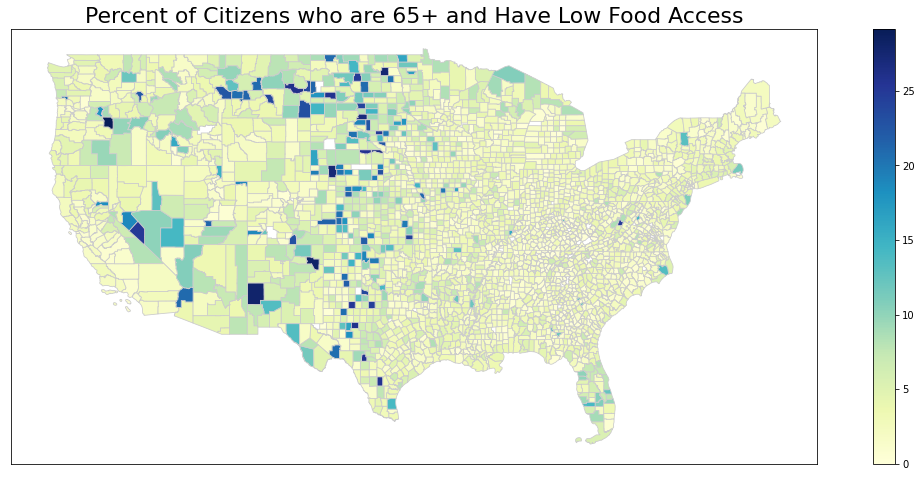

In [9]:
import geopandas as gpd
from matplotlib.colors import LogNorm
import matplotlib.colors as colors

# Read the counties shapefile
counties = gpd.read_file('shp_files/tl_rd22_us_county.shp')

# Rename GEOID for merging
counties.rename(columns={'GEOID':'State_CountyFIPS'}, inplace=True)

# Restrict to include only continental US (only for plotting = HI and AK are included in rest of analysis)
continental_us_bbox = [-125, 24, -66, 49]  # [minx, miny, maxx, maxy]
counties = counties.cx[continental_us_bbox[0]:continental_us_bbox[2],
                      continental_us_bbox[1]:continental_us_bbox[3]]

# Merge food data onto counties via State_CountyFIPS
counties_food = counties.merge(food, on='State_CountyFIPS', how='left')

# Plot
fig, ax = plt.subplots(figsize=(20, 8))
counties_food.plot(column='PCT_LACCESS_SENIORS15', cmap='YlGnBu', linewidth=0.8, 
                   ax=ax, edgecolor='0.8', legend=True)

# Options
ax.set_facecolor('white')
plt.title('Percent of Citizens who are 65+ and Have Low Food Access', fontsize=22)
plt.xticks([])
plt.yticks([])

for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Display 
plt.show()

## B. Plotting Impact vs. Population at-risk

### Create and normalize variables

In [10]:
# For Z score
from scipy.stats import zscore

# Create variables
food['pct_sr_of_laccess'] = food['LACCESS_SENIORS15']/food['LACCESS_POP15']
food['pct_black_of_laccess'] = food['LACCESS_BLACK15']/food['LACCESS_POP15']
food['pct_lowi_of_laccess'] = food['LACCESS_LOWI15']/food['LACCESS_POP15']
food_plot = food[['State_CountyFIPS', 'FIPS', 'State', 'County', 'population', 'LACCESS_SENIORS15', 
                  'pct_sr_of_laccess', 'pct_black_of_laccess', 'PCT_LACCESS_HHNV15', 'pct_lowi_of_laccess', 'PCT_LACCESS_SNAP15']].copy()

# Set variables to normalize via. Z score
vars_to_normalize = ['pct_black_of_laccess', 'PCT_LACCESS_HHNV15', 'pct_lowi_of_laccess', 'PCT_LACCESS_SNAP15']

# Normalize
for var in vars_to_normalize:
    var_name = f'{var}_z'
    food_plot[var_name] = zscore(food_plot[var])
    
# Sum across normalized vars to create impact score
food_plot['impact_score'] = food_plot.loc[:, 'pct_black_of_laccess_z':'PCT_LACCESS_SNAP15_z'].sum(axis=1)
food_plot

,State_CountyFIPS,FIPS,State,County,population,LACCESS_SENIORS15,pct_sr_of_laccess,pct_black_of_laccess,PCT_LACCESS_HHNV15,pct_lowi_of_laccess,PCT_LACCESS_SNAP15,pct_black_of_laccess_z,PCT_LACCESS_HHNV15_z,pct_lowi_of_laccess_z,PCT_LACCESS_SNAP15_z,impact_score
0,01001,01001,AL,Autauga,54571.0,2180.809285,0.124641,0.240987,3.351332,0.373995,4.608749,0.934806,0.025165,-0.021222,0.541622,1.480372
1,01003,01003,AL,Baldwin,182265.0,5580.662790,0.182606,0.115865,1.905114,0.323509,1.298900,0.150472,-0.427078,-0.443738,-0.519036,-1.239380
2,01005,01005,AL,Barbour,27457.0,824.175262,0.135789,0.447008,4.329378,0.485836,4.303147,2.226257,0.331008,0.914758,0.443690,3.915714
3,01007,01007,AL,Bibb,22915.0,137.688231,0.142038,0.432339,2.821427,0.614995,0.676710,2.134303,-0.140540,1.995676,-0.718420,3.271019
4,01009,01009,AL,Blount,57322.0,505.914282,0.135837,0.025734,3.336414,0.443279,0.812727,-0.414518,0.020501,0.558604,-0.674833,-0.510246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,56037,WY,Sweetwater,43806.0,1951.212126,0.103049,0.009838,2.182752,0.250910,2.141828,-0.514160,-0.340259,-1.051311,-0.248916,-2.154646
3139,56039,56039,WY,Teton,21294.0,657.160241,0.105782,0.001463,0.540222,0.253972,0.670815,-0.566657,-0.853891,-1.025684,-0.720309,-3.166542
3140,56041,56041,WY,Uinta,21118.0,437.130401,0.093284,0.003199,2.759922,0.438364,2.072485,-0.555777,-0.159773,0.517471,-0.271137,-0.469216
3141,56043,56043,WY,Washakie,8533.0,219.490015,0.235653,0.002147,1.203633,0.331787,1.053980,-0.562369,-0.646437,-0.374456,-0.597522,-2.180785


### Plot

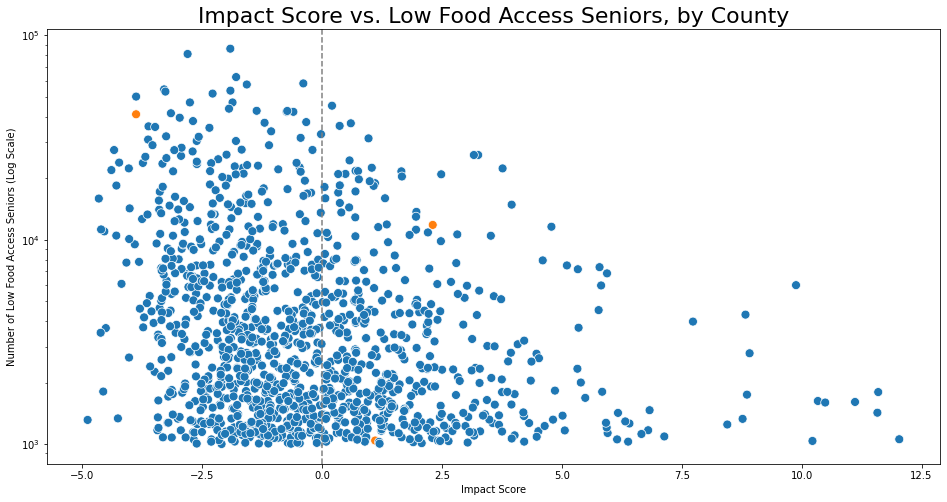

In [11]:
# Restrict to include those with > 1000 SSs with low access
food_plot_r = food_plot[food_plot.LACCESS_SENIORS15 > 1000].copy()
food_plot_r['special_pt'] = "No"
food_plot_r.loc[food_plot_r['FIPS'].isin(["09001", "35003", "45083"]), 'special_pt'] = "Yes"

# Plot
plt.figure(figsize=(16, 8)) 
sns.scatterplot(data=food_plot_r, x='impact_score', y='LACCESS_SENIORS15', hue='special_pt', s=80, legend=False)
plt.axvline(x=0, color='gray', linestyle='--')

# Options
plt.yscale('log')
plt.title('Impact Score vs. Low Food Access Seniors, by County', fontsize=22)
plt.xlabel('Impact Score')
plt.ylabel('Number of Low Food Access Seniors (Log Scale)')

# Show
plt.show()


## C. Aggregated highly impact-able population by State, with race breakdown


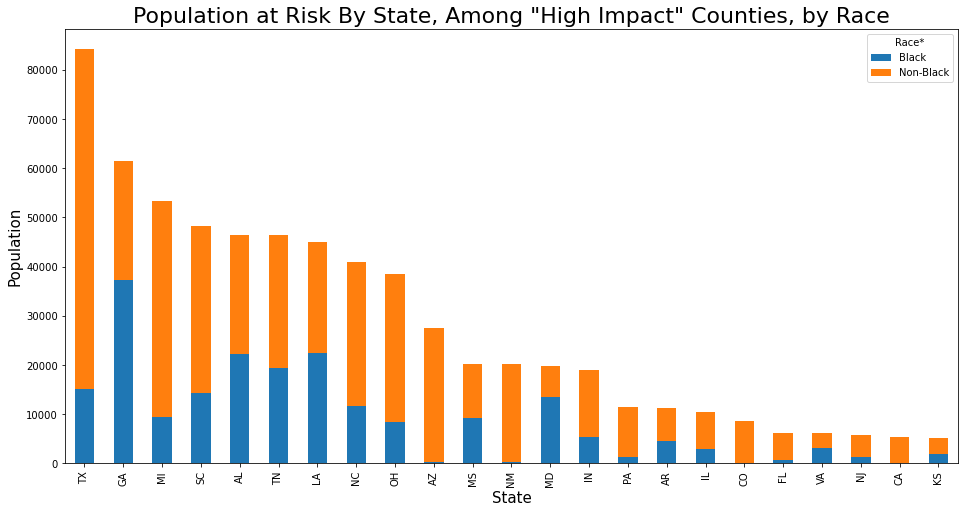

In [12]:
# New dataset
food_race = food.copy()

# Aggregate
food_race_agg = pd.merge(food_race, food_plot[['State_CountyFIPS', 'impact_score']], on='State_CountyFIPS', how='left')
food_race_agg = food_race_agg[(food_race_agg.LACCESS_SENIORS15 > 5000) & (food_race_agg.impact_score > 0.75)]
food_race_agg = food_race_agg.groupby('State').agg(
    PopAtRiskTotal=('LACCESS_POP15', 'sum'),
    PopAtRiskSr=('LACCESS_SENIORS15', 'sum'),
    PopAtRiskBlack=('LACCESS_BLACK15', 'sum'),
    Count=('LACCESS_SENIORS15', 'count')
).sort_values('PopAtRiskSr', ascending=False).reset_index()

# Round
food_race_agg.loc[:, 'PopAtRiskTotal':'PopAtRiskBlack'] = food_race_agg.loc[:,'PopAtRiskTotal':'PopAtRiskBlack'].round().astype(int)
food_race_agg['total_not_black'] = food_race_agg['PopAtRiskTotal'] - food_race_agg['PopAtRiskBlack']  
food_race_agg['total_black_sr'] = (food_race_agg['PopAtRiskBlack'] / food_race_agg['PopAtRiskTotal'] * food_race_agg['PopAtRiskSr']).round().astype(int)
food_race_agg['total_not_black_sr'] = (food_race_agg['PopAtRiskSr'] - food_race_agg['total_black_sr']).round().astype(int)

# Plot
food_race_agg.set_index('State')[['total_black_sr', 'total_not_black_sr']].plot(kind='bar', stacked=True)

# Options
plt.gcf().set_size_inches(16, 8)
plt.xlabel('State', fontsize=15)
plt.ylabel('Population', fontsize=15)
plt.title('Population at Risk By State, Among "High Impact" Counties, by Race', fontsize=22)
plt.legend(title='Race*', labels=['Black', 'Non-Black'])
plt.xticks(rotation=90)

# Display
plt.show()